In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


In [4]:
from sklearn import *
from tensorflow import keras as keras
# import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_digits
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from tensorboard.plugins import projector

from sklearn.model_selection import train_test_split



In [5]:
root_dir = 'C:\\Users\\Shantanu\\Dropbox\\Capstone\\Wikipedia Data\\'

# root_dir = r'/Users/shantanu/Library/Mobile Documents/com~apple~CloudDocs/Capstone/Wikipedia Data'

result_path = annot_file_path = os.path.join(root_dir , 'comments_with_grouped_annoptations.tsv')

merged_comments = pd.read_table(result_path)

In [6]:
merged_comments['recipient_attack'] = merged_comments['recipient_attack'].apply(lambda x : 1 if x> 1 else 0 )
X_train = merged_comments['comment']
y = merged_comments['recipient_attack']
one_hot_train_labels = to_categorical(y)

In [7]:
merged_comments['new_attack'] = merged_comments['attack'].apply(lambda x : 1 if x> 1 else 0 )

In [8]:
# Prepare training input  
training_samples = 0.60
validation_samples = 0.40
max_words = 15000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 187899 unique tokens.


In [9]:
maxlen = 150

In [10]:
data = pad_sequences(sequences, maxlen=maxlen)
print('Shape of data tensor:', data.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
# x_train = data[:training_samples]
# x_val = data[training_samples: (training_samples + validation_samples)]
# x_test = data[(training_samples + validation_samples) : ]

Shape of data tensor: (115864, 150)


In [11]:
# Prepare labels 
labels = np.asarray(one_hot_train_labels)
print('Shape of label tensor:', labels.shape)
labels = labels[indices]
# y_train = labels[:training_samples]
# y_val = labels[training_samples: training_samples + validation_samples]
# y_test = labels[(training_samples + validation_samples) : ]

Shape of label tensor: (115864, 2)


In [12]:
#### Stratified Test Train Validation Split 

### First Lets do 60 and 40. 

X_train, X_test_validate, y_train, y_test_validate = train_test_split(data, labels,
                                                    stratify=labels, 
                                                    test_size=0.40,
                                                    random_state=123)




In [13]:
### Then 20% for Testing and Validation 

X_test, X_validate, y_test, y_validate = train_test_split(X_test_validate, y_test_validate,
                                                    stratify = y_test_validate, 
                                                    test_size=0.50,
                                                    random_state=123)



In [14]:
len(X_train)+len(X_test)+len(X_validate)


115864

In [15]:
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [16]:
from tensorflow.keras.layers import LSTM
embedding_dim = 100
model = Sequential()
#embedding = Embedding(max_words, embedding_dim , weights =w)
embedding = Embedding(max_words, embedding_dim)

#embedding.trainable = False
model.add(embedding)
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(64))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,668,802
Trainable params: 1,668,802
Non-trainable params: 0
______________________________________________

In [18]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(X_train, y_train,
epochs= 12,
batch_size=256,
callbacks = [ES],
validation_data=(X_validate, y_validate))

Train on 69518 samples, validate on 23173 samples
Epoch 1/12
69518/69518 [==============================] - 231s 3ms/sample - loss: 0.3775 - acc: 0.8435 - val_loss: 0.3205 - val_acc: 0.8691
Epoch 2/12
69518/69518 [==============================] - 243s 4ms/sample - loss: 0.3021 - acc: 0.8760 - val_loss: 0.3099 - val_acc: 0.8760
Epoch 3/12
69518/69518 [==============================] - 245s 4ms/sample - loss: 0.2872 - acc: 0.8824 - val_loss: 0.3107 - val_acc: 0.8773
Epoch 4/12
69518/69518 [==============================] - 245s 4ms/sample - loss: 0.2777 - acc: 0.8866 - val_loss: 0.3296 - val_acc: 0.8737
Epoch 00004: early stopping


In [19]:
model.save('LSTM_Model.h5')

In [23]:
from tensorflow.keras.models import load_model

In [24]:
model1 = load_model('LSTM_Model.h5')

In [47]:
X_test[1].shape

(150,)

In [63]:
X_test.shape

(23173, 150)

In [64]:
test_output = model1.predict([X_test])

In [65]:
test_output.shape

(23173, 2)

In [66]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,668,802
Trainable params: 1,668,802
Non-trainable params: 0
______________________________________________

In [69]:
y_pred = np.np.argmax([test_output])

In [70]:
y_pred

13150

In [71]:
test_output[0:5]

array([[0.98890555, 0.01099252],
       [0.7829233 , 0.22364411],
       [0.9394743 , 0.0608976 ],
       [0.98645824, 0.01349656],
       [0.9942334 , 0.005299  ]], dtype=float32)

In [78]:
y_pred = list(map(lambda x: np.argmax(x), test_output))
y_test_bin = list(map(lambda x: np.argmax(x), y_test))

In [79]:
from sklearn.metrics import confusion_matrix

In [93]:
cfm = confusion_matrix(y_test_bin,y_pred)

In [85]:
from sklearn.metrics import accuracy_score

In [87]:
print(accuracy_score(y_test_bin,y_pred))

0.8714020627454365


In [82]:
from sklearn.metrics import classification_report

In [83]:
report = classification_report(y_test_bin,y_pred)

In [84]:
print(report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     17835
           1       0.84      0.55      0.66      5338

    accuracy                           0.87     23173
   macro avg       0.86      0.76      0.79     23173
weighted avg       0.87      0.87      0.86     23173



In [88]:
from sklearn.metrics import plot_confusion_matrix

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 257.44, 'Predicted label')

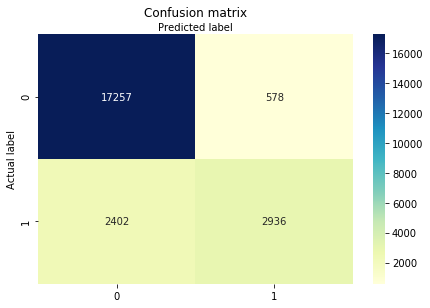

In [95]:
class_names=["Non-Toxic","Toxic"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cfm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [138]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

In [139]:
#### Testing ELMO

import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/elmo/3"
embed = hub.load(module_url)

In [140]:
merged_comments.head()

,Unnamed: 0,rev_id,comment,year,logged_in,ns,sample,split,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack,new_attack
0,0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,9721,0.0,0,0.0,0.0,0.0,0
1,1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train,20234,0.0,0,0.0,0.0,0.0,0
2,2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train,26474,0.0,0,0.0,0.0,0.0,0
3,3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,26738,0.0,1,0.0,2.0,4.0,1
4,4,93890,This page will need disambiguation.,2002,True,article,random,train,8010,0.0,0,0.0,0.0,0.0,0


In [141]:
X_train, X_test_validate, y_train, y_test_validate = train_test_split(merged_comments.comment, merged_comments.recipient_attack,
                                                    stratify=labels, 
                                                    test_size=0.40,
                                                    random_state=123)

In [142]:
DF_train = X_train.to_frame()

In [143]:
DF_train['recipient_attack'] = y_train

In [144]:
DF_train.head()

,comment,recipient_attack
58487,`NEWLINE_TOKENNEWLINE_TOKEN==Aliases==NEWLINE_...,0
107062,NEWLINE_TOKENDoug: What is this assault on me ...,0
39257,`NEWLINE_TOKENNEWLINE_TOKEN:::So what? That's ...,0
19052,Thank you for experimenting with Wikipedia. Yo...,0
108173,NEWLINE_TOKENNEWLINE_TOKEN== 2014 sterilisatio...,0


In [145]:
DF_train.reset_index(inplace=True)

In [168]:
DF_train.head()

,index,comment,recipient_attack
0,58487,`NEWLINE_TOKENNEWLINE_TOKEN==Aliases==NEWLINE_...,0
1,107062,NEWLINE_TOKENDoug: What is this assault on me ...,0
2,39257,`NEWLINE_TOKENNEWLINE_TOKEN:::So what? That's ...,0
3,19052,Thank you for experimenting with Wikipedia. Yo...,0
4,108173,NEWLINE_TOKENNEWLINE_TOKEN== 2014 sterilisatio...,0


In [146]:
def preprocess_text(text_eval):
    sequences = tokenizer.texts_to_sequences([text_eval])
    data = pad_sequences(sequences, maxlen=maxlen)
    return data

In [159]:
DF_train.index[0:10]

RangeIndex(start=0, stop=10, step=1)

In [186]:
NAE_vals_array = np.empty((0,1024), float)
PAE_vals_array = np.empty((0,1024), float)

In [187]:
NAE_vals_array

array([], shape=(0, 1024), dtype=float64)

In [188]:
PAE_vals_array

array([], shape=(0, 1024), dtype=float64)

In [199]:
### Abalation and Get the Vectors of the important trigrams 

NAE_vals_array = np.empty((0,1024), float)
PAE_vals_array = np.empty((0,1024), float)

for index, row in DF_train.iterrows():
    
    text = row.comment.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)
    tokens_without_sw = [word for word in tokens if not word in stopwords.words()]
    
    ### First Get the overall Classification
    
    pred_vlaues = model.predict(preprocess_text(str(tokens_without_sw)))
    
    classification = pred_vlaues.argmax()
    
    if classification == 0 and row.recipient_attack == 0:
        mode = 'PAE' # Positive AutoEncoder
    elif classification == 0 and row.recipient_attack == 1:
        mode = 'NAE'
    elif classification == 1 and row.recipient_attack == 0:
        mode = 'PAE'
    elif classification == 1 and row.recipient_attack == 1:
        mode = 'NAE'
        
    ### Get the Elmo vector
    
    text=tf.convert_to_tensor([str(tokens_without_sw)])
    out = embed.signatures['default'](text)['elmo']
  
    pred_vals_array = np.empty((0,2), float)
    
    for i in range(len(tokens_without_sw)-2):
        
        
        
        text_eval = tokens_without_sw[i:i+3]

        a = preprocess_text(str(text_eval))
        pred_vlaues = model.predict(a)
        pred_vals_array = np.vstack((pred_vals_array,pred_vlaues))
        
    if mode == "NAE":

        # Only Negative Vals, and find the index of the highest contributing phrase

        phrase_start_index = pred_vals_array[:,1].argmax()

        ### Get the ELMO Encoding of the entire vector:

        elmo_vecs = np.array(out[0][phrase_start_index:phrase_start_index+3])

        NAE_vals_array = np.vstack((NAE_vals_array, elmo_vecs))
        
        print("NAE")
        print(len(NAE_vals_array))

    elif mode == "PAE":

        # Only Positive Vals, and find the index of the highest contributing phrase

        phrase_start_index = pred_vals_array[:,0].argmax()

        PAE_vals_array = np.vstack((PAE_vals_array,out[0][phrase_start_index:phrase_start_index+3]))
        
        print("PAE")
        print(len(PAE_vals_array))

    if index == 20:
        break

PAE
3
PAE
6
PAE
9
PAE
12
PAE
15
NAE
3
PAE
18
PAE
21
PAE
24
PAE
27
PAE
30
PAE
33
PAE
36
PAE
39
PAE
42
PAE
45
PAE
48
PAE
51
NAE
6
NAE
9
NAE
12


In [200]:
NAE_vals_array.shape

(12, 1024)

In [201]:
PAE_vals_array.shape

(51, 1024)

In [202]:
NAE_vals_array = NAE_vals_array.reshape(int(NAE_vals_array.shape[0]/3),3,1024)
PAE_vals_array = PAE_vals_array.reshape(int(PAE_vals_array.shape[0]/3),3,1024)


In [203]:
PAE_vals_array.shape

(17, 3, 1024)

In [204]:
# lstm autoencoder to recreate a timeseries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

In [205]:
timesteps = 3
n_features = 1024
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# define model
model_TAE = Sequential()
model_TAE .add(LSTM(1024, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model_TAE .add(LSTM(720, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model_TAE .add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model_TAE .add(LSTM(64, activation='relu', return_sequences=False))
model_TAE .add(RepeatVector(timesteps))
model_TAE .add(LSTM(64, activation='relu', return_sequences=True))
model_TAE .add(LSTM(128, activation='relu', return_sequences=True))
model_TAE .add(LSTM(720, activation='relu', return_sequences=True))
model_TAE .add(LSTM(1027, activation='relu', return_sequences=True))
model_TAE .add(TimeDistributed(Dense(n_features)))
model_TAE .compile(optimizer='adam', loss='mse')
model_TAE.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 3, 1024)           8392704   
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 720)            5025600   
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 128)            434688    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
lstm_17 (LSTM)               (None, 3, 128)           

In [207]:
model_TAE.fit(PAE_vals_array, PAE_vals_array, epochs=3, batch_size=5)

Train on 17 samples
Epoch 1/3
17/17 [==============================] - 2s 103ms/sample - loss: 0.2875
Epoch 2/3
17/17 [==============================] - 2s 101ms/sample - loss: 0.2820
Epoch 3/3
17/17 [==============================] - 2s 103ms/sample - loss: 0.2703
